# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch 
from collections import deque, namedtuple
import random
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from model import Actor, Critic

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1
LEARN_NUMBER = 3
EPSILON = 1.0
EPSILON_DECAY = 0.99
CLIPGRAD = .1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.standard_normal(size=x.shape))

        self.state = x + dx
        return self.state
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class DDPGAgent:
    def __init__(self, output_size, input_size,name, hidden = 256, lr_actor=1.0e-3, lr_critic=1.0e-3, tau = 1.0e-2, seed = 10):
        super(DDPGAgent, self).__init__()
        
        self.seed = seed
        self.actor         = Actor(input_size, hidden, output_size, seed).to(device)
        self.critic        = Critic(input_dim = input_size, action_dim = action_size, hidden = hidden, seed = seed, output_dim = 1).to(device)
        self.target_actor  = Actor(input_size, hidden, output_size, seed).to(device)
        self.target_critic = Critic(input_dim = input_size, action_dim = action_size, hidden = hidden, seed = seed, output_dim = 1).to(device)
        self.name = name
        self.noise = OUNoise(output_size, seed)
        self.tau = tau
        self.epsilon = EPSILON
        self.gamma = GAMMA
        self.clipgrad = CLIPGRAD
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic, weight_decay=0)
       

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) #.unsqueeze(0)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().squeeze(0).data.numpy()

        self.actor.train()
        if add_noise:
            action += self.noise.sample() * self.epsilon
        return np.clip(action, -1, 1)
    
    
    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.target_actor(next_states.to(device))
        #set_trace()
        Q_targets_next = self.target_critic(next_states.to(device), actions_next.to(device))
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(self.critic.parameters(), self.clipgrad)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        #clip_grad_norm_(self.actor.parameters(), self.clipgrad)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic, self.target_critic )
        self.soft_update(self.actor, self.target_actor)                     
        
        # ----------------------- update epsilon and noise ----------------------- #
        self.epsilon *= EPSILON_DECAY
        self.noise.reset()

    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)   
            
class MADDPG:
    def __init__(self, seed = 99):
        super(MADDPG, self).__init__()

        self.maddpg_agent = [DDPGAgent(action_size, state_size, 1), 
                             DDPGAgent(action_size, state_size, 2)]
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

    def act(self, observations):
        """get actions from all agents in the MADDPG object"""

        actions = [agent.act(obs) for agent, obs in zip(self.maddpg_agent,observations)]
        return actions

    def step(self, state, action, reward, next_state, done, timestamp):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        #for idx, agent in enumerate(self.maddpg_agent):
            self.memory.add(state, action, reward, next_state, done)

            
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestamp % LEARN_EVERY == 0:
            for agent in self.maddpg_agent:
                for _ in range(LEARN_NUMBER):
                    experiences = self.memory.sample()
                    agent.learn(experiences)

In [9]:
maddpg = MADDPG()
max_episodes = 4000

reward_history = []
scores_100 = deque(maxlen=100)
time_stamp = 1
episodic_rewards = []
print_every = 50 
print("Training runs!\n")
for i_episode in range(max_episodes):                                  # play game for max_episodes
    env_info = env.reset(train_mode=True)[brain_name]                  # reset the environment    
    states = env_info.vector_observations                              # get the current state (for each agent)
    scores = np.zeros(num_agents)
        
    while True:
        actions = maddpg.act(states)                                   # select an action (for each agent)
        env_info = env.step(actions)[brain_name]                       # send all actions to tne environment
        next_states = env_info.vector_observations                     # get next state (for each agent)
        rewards = env_info.rewards                                     # get reward (for each agent)
        dones = env_info.local_done                                    # see if episode finished
        scores += env_info.rewards                                     # update the score (for each agent)
        maddpg.step(states, actions, rewards, next_states, dones, time_stamp)
        states = next_states                                           # roll over states to next time step
        time_stamp +=1

        if np.any(dones):                                              # exit loop if the episode is finished
            break
    max_ = np.max(scores)
    episodic_rewards.append(max_)
    scores_100.append(max_)
    if i_episode % print_every == 0:
        print('\rEpisode {}  Average_Score: {:.2f}'.format(i_episode, np.mean(scores_100)))
    if np.mean(scores_100) >= 0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage_Score: {:.2f}'.format(i_episode, np.mean(scores_100)))
        for idx, agent in enumerate(maddpg.maddpg_agent):
            torch.save(agent.actor.state_dict(), "actor_agent"+str(idx)+".pth")
            torch.save(agent.critic.state_dict(), "critic_agent"+str(idx)+".pth")
        break

Training runs!

Episode 0  Average_Score: 0.00
Episode 50  Average_Score: 0.01
Episode 100  Average_Score: 0.04
Episode 150  Average_Score: 0.08
Episode 200  Average_Score: 0.10
Episode 250  Average_Score: 0.13
Episode 300  Average_Score: 0.31

Environment solved in 331 episodes!	Average_Score: 0.51


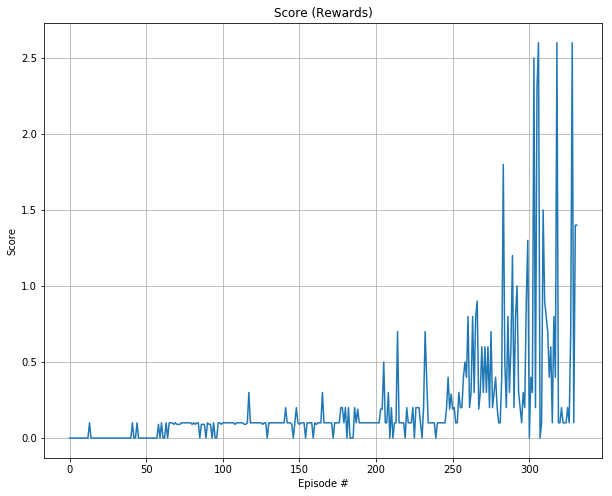

In [10]:
# plot the scores
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episodic_rewards)), episodic_rewards)
plt.title('Score (Rewards)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.show()